<a href="https://colab.research.google.com/github/RicardoVillena/Base-de-datos/blob/main/4_1_1_1_MC_RL_BlackJack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Nicky van Foreest(vanforeest@gmail.com)                        #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

Parte teórica: Sutton, Richard S. "Reinforcement learning: An introduction." A Bradford Book (2018).

# **Ejemplo del Jueglo de Blackjack**

## Reglas

El juego comienzo con dos cartas repartidas tanto al dealer como al jugador.
Una de las cartas del dealer está boca arriba y la otra boca abajo.
Si el jugador tiene 21 inmediatamente (un as y una cata de 10), se llama natural. Entonces gana al menos que el dealer también tenga un natural, en cuyo caso el juego es un empate.
Si el jugador no tiene un natural, entonces puede pedir cartas adicionales, una por una (pedir carta), hasta que se detenga (plantarse) o superar los 21 (pasarse). Si se pasa, pierde; si se planta, entonces es el turno del dealer. El dealer pide o se planta de acuerdo con una estrategia fija sin elección: se planta con cualquier suma de 17 o más, y pide carta en caso contrario. Si el dealer se pasa, entonces el jugador gana. De lo contrario, el resultado (ganar, derrota, o empate) se determina según la suma final que este más cerca de 21.
Si el jugador tiene un as que podría contar como 11 sin pasarse, se dice que el as es utilizable.



*   Estados (200 de ellos):
  *   Suma actual (12 - 21)
  *   Carta mostrada por el dealer (as - 10)
  *   ¿Tengo un as utilizable? (sí/no)
*   Acción de quedarse: dejar de recibir cartas (y terminar)
*   Acción de girar: tomar otra carta (sin reemplazo)
*   Recompensa por quedarse:
  *   +1 si la suma de cartas > suma de cartas del dealer
  *   0 si la suma de cartas = suma de cartas del dealer
  *   -1 si la suma de cartas < suma de cartas del dealer
*   Recompensa de girar:
  *   -1 si la suma de cartas > 21 (y terminar)
  *   0 en caso contrario
*   Transición: Girar automaticamente si la suma de cartas < 12



## Variables

In [ ]:
# acciones: girar (hit) or quedarse(stand)
ACTION_HIT = 0
ACTION_STAND = 1
ACTIONS = [ACTION_HIT, ACTION_STAND]

def get_card():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

# obtener valor de las cartas (11 para as).
def card_value(card_id):
    return 11 if card_id == 1 else card_id

## Políticas

### Política del *dealer*

In [ ]:
POLICY_PLAYER = np.zeros(22, dtype=int)
for i in range(12, 20):
    POLICY_PLAYER[i] = ACTION_HIT
POLICY_PLAYER[20] = ACTION_STAND
POLICY_PLAYER[21] = ACTION_STAND

# funcion de la politica objetivo del jugador
def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

# funcion de la politica de comportamiento del jugador
def behavior_policy_player(usable_ace_player, player_sum, dealer_card):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT


In [ ]:
POLICY_DEALER = np.zeros(22)
for i in range(12, 17):
    POLICY_DEALER[i] = ACTION_HIT
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND

## Juego

In [ ]:
# Jugar el juego
# @policy_player: politica especifica del jugador
# @initial_state: [si el jugador tiene un AS utilizable, suma las caratas del juegador, una carta del dealer]
# @initial_action: inicializar las acciones
def play(policy_player, initial_state=None, initial_action=None):
    # suma del jugador
    player_sum = 0

    # trayectoria del jugador
    player_trajectory = []

    # si el jugador usa el AS como 11
    usable_ace_player = False

    # status del dealer
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False

    if initial_state is None:
        # generar el estado inicial aleatoriamente

        while player_sum < 12:
            # Si la suma del jugador es menor que 12, siempre gira (hit)
            card = get_card()
            player_sum += card_value(card)

            # Si la suma del jugador es mayor que 21, puede ser que se tiene 1 o 2 ASES.
            if player_sum > 21:
                assert player_sum == 22
                # la ultima carta debe ser un AS
                player_sum -= 10
            else:
                usable_ace_player |= (1 == card)

        # inicializar las cartas del dealer, suponsamos que el dealer mostrar la
        # primera carta que reciba
        dealer_card1 = get_card()
        dealer_card2 = get_card()

    else:
        # usar un estado especifico de inicio
        usable_ace_player, player_sum, dealer_card1 = initial_state
        dealer_card2 = get_card()

    # estado inicial del juego
    state = [usable_ace_player, player_sum, dealer_card1]

    # iniciar la suma del dealer
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
    # Si el dealer tiene una suma mayor que 21, puede ser que tenga 2 ASES
    if dealer_surm > 21:
        assert dealer_sum == 22
        # Usar el AS como 1 en luga de 11
        dealer_sum -= 10
    assert dealer_sum <= 21
    assert player_sum <= 21

    # Juego empieza

    # Turno del Jugador
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            # tomar la accion basa en la suma actual
            action = policy_player(usable_ace_player, player_sum, dealer_card1)

        # Realizar un seguimiento de la trayectoria del jugador para el muestreo
        # de importancia
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action == ACTION_STAND:
            break
        # Si gira, obtener nueva carta
        card = get_card()
        # Mantener un registo del conteo de ASES. El indicador usable_ace_player por
        # si solo no es suficiente ya que no puede distinguir entre tener 1 AS o 2
        ace_count = int(usable_ace_player)
        if card == 1:
            ace_count += 1
        player_sum += card_value(card)
        # Si el jugador tiene un AS utilizable, uselo como 1 para evitar pasarse y contiuar
        while player_sum > 21 and ace_count:
            player_sum -= 10
            ace_count -= 1
        # Quedarse (jugador)
        if player_sum > 21:
            return state, -1, player_trajectory
        assert player_sum <= 21
        usable_ace_player = (ace_count == 1)

    # Turno del dealer
    while True:
        # obtener accion basada en la suma actual
        action = POLICY_DEALER[dealer_sum]
        if action == ACTION_STAND:
            break
        # Si es girar, obtener una nueva carta
        new_card = get_card()
        ace_count = int(usable_ace_dealer)
        if new_card == 1:
            ace_count += 1
        dealer_sum += card_value(new_card)
        # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
        while dealer_sum > 21 and ace_count:
            dealer_sum -= 10
            ace_count -= 1
        # dealer quedarse
        if dealer_sum > 21:
            return state, 1, player_trajectory
        usable_ace_dealer = (ace_count == 1)

    # comparar la suma entre dealer y jugador
    assert player_sum <= 21 and dealer_sum <= 21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory


## **Monte Carlo**


Los métodos de Monte Carlo son formas de resolver el problemas del aprendizaje por refuerzo basado en el promedio de los entornos de muestra. Para garantizar que se disponga de retornos bien definidos, solo para tareas episódicas. Es decir, suponemos que la experiencia se divide en episodios y que todos los episodios terminan eventualmente sin importar qué acciones se seleccionen.  Solo cuando se completa un episodio se modifican las estimaciones de valor y las políticas.

Los métodos de Monte Carlo muestrean y promedian los retornos para cada par estado-acción de manera muy similar a los métodos bandits.

### MC con inicios exploratorios (MC ES)


Para la iteración de políticas de Monte-Carlo es natural alternar entre evaluación y mejora episodio por episodio. Después de cada episodio, los retornos observador se utilizan para la evaluación de políticas y luego se mejora la política en todos los estados visitados en el episodio. Un algoritmo simple completo en este línea, que llamamos Monte Carlo con inicios exploratorios (MC ES).

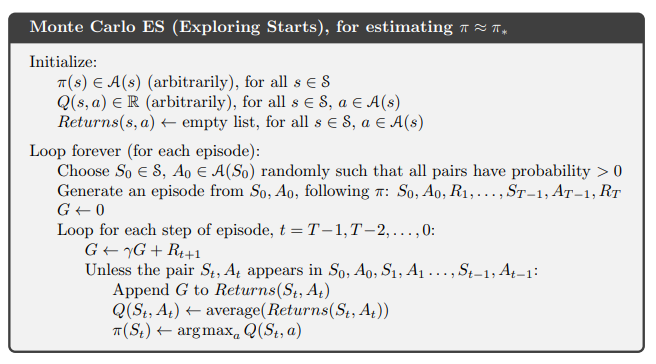

Es sencillo aplicar el método Monte Carlo ES al Blackjack. COmo todos lso episodios son juegos simulados, es fácil orgnaizar inicios de exploración que incluyan todas las posibilidades. En este caso, uno simplemente elige las cartas del dealer, la suma del jugador y si el jugador tiene o no un AS utilizable, todo al aza con la misma probabilidad. Como política inicial usamos la política evaluada en el ejemplo anterior de Blackjack, la que se queda solo en 20 o 21.
La función acción-valor inicial puede ser cero para todos los pares estado-accion.

In [ ]:
def monte_carlo_es(episodes):
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # behavior policy is greedy
    def behavior_policy(usable_ace, player_sum, dealer_card):
        usable_ace = int(usable_ace)
        player_sum -= 12
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        values_ = state_action_values[player_sum, dealer_card, usable_ace, :] / \
                  state_action_pair_count[player_sum, dealer_card, usable_ace, :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    for episode in tqdm(range(episodes)):
        # for each episode, use a randomly initialized state and action
        initial_state = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initial_action = np.random.choice(ACTIONS)
        current_policy = behavior_policy if episode else target_policy_player
        _, reward, trajectory = play(current_policy, initial_state, initial_action)
        first_visit_check = set()
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            state_action = (usable_ace, player_sum, dealer_card, action)
            if state_action in first_visit_check:
                continue
            first_visit_check.add(state_action)
            # update values of state-action pairs
            state_action_values[player_sum, dealer_card, usable_ace, action] += reward
            state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1

    return state_action_values / state_action_pair_count


In [ ]:
def test_MC_ExplorationStart():
    state_action_values = monte_carlo_es(500000)

    state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
    state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

    # get the optimal policy
    action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
    action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

    images = [action_usable_ace,
              state_value_usable_ace,
              action_no_usable_ace,
              state_value_no_usable_ace]

    titles = ['Optimal policy with usable Ace',
              'Optimal value with usable Ace',
              'Optimal policy without usable Ace',
              'Optimal value without usable Ace']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for image, title, axis in zip(images, titles, axes):
        fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)

    plt.show()

100%|██████████| 500000/500000 [01:20<00:00, 6246.68it/s]


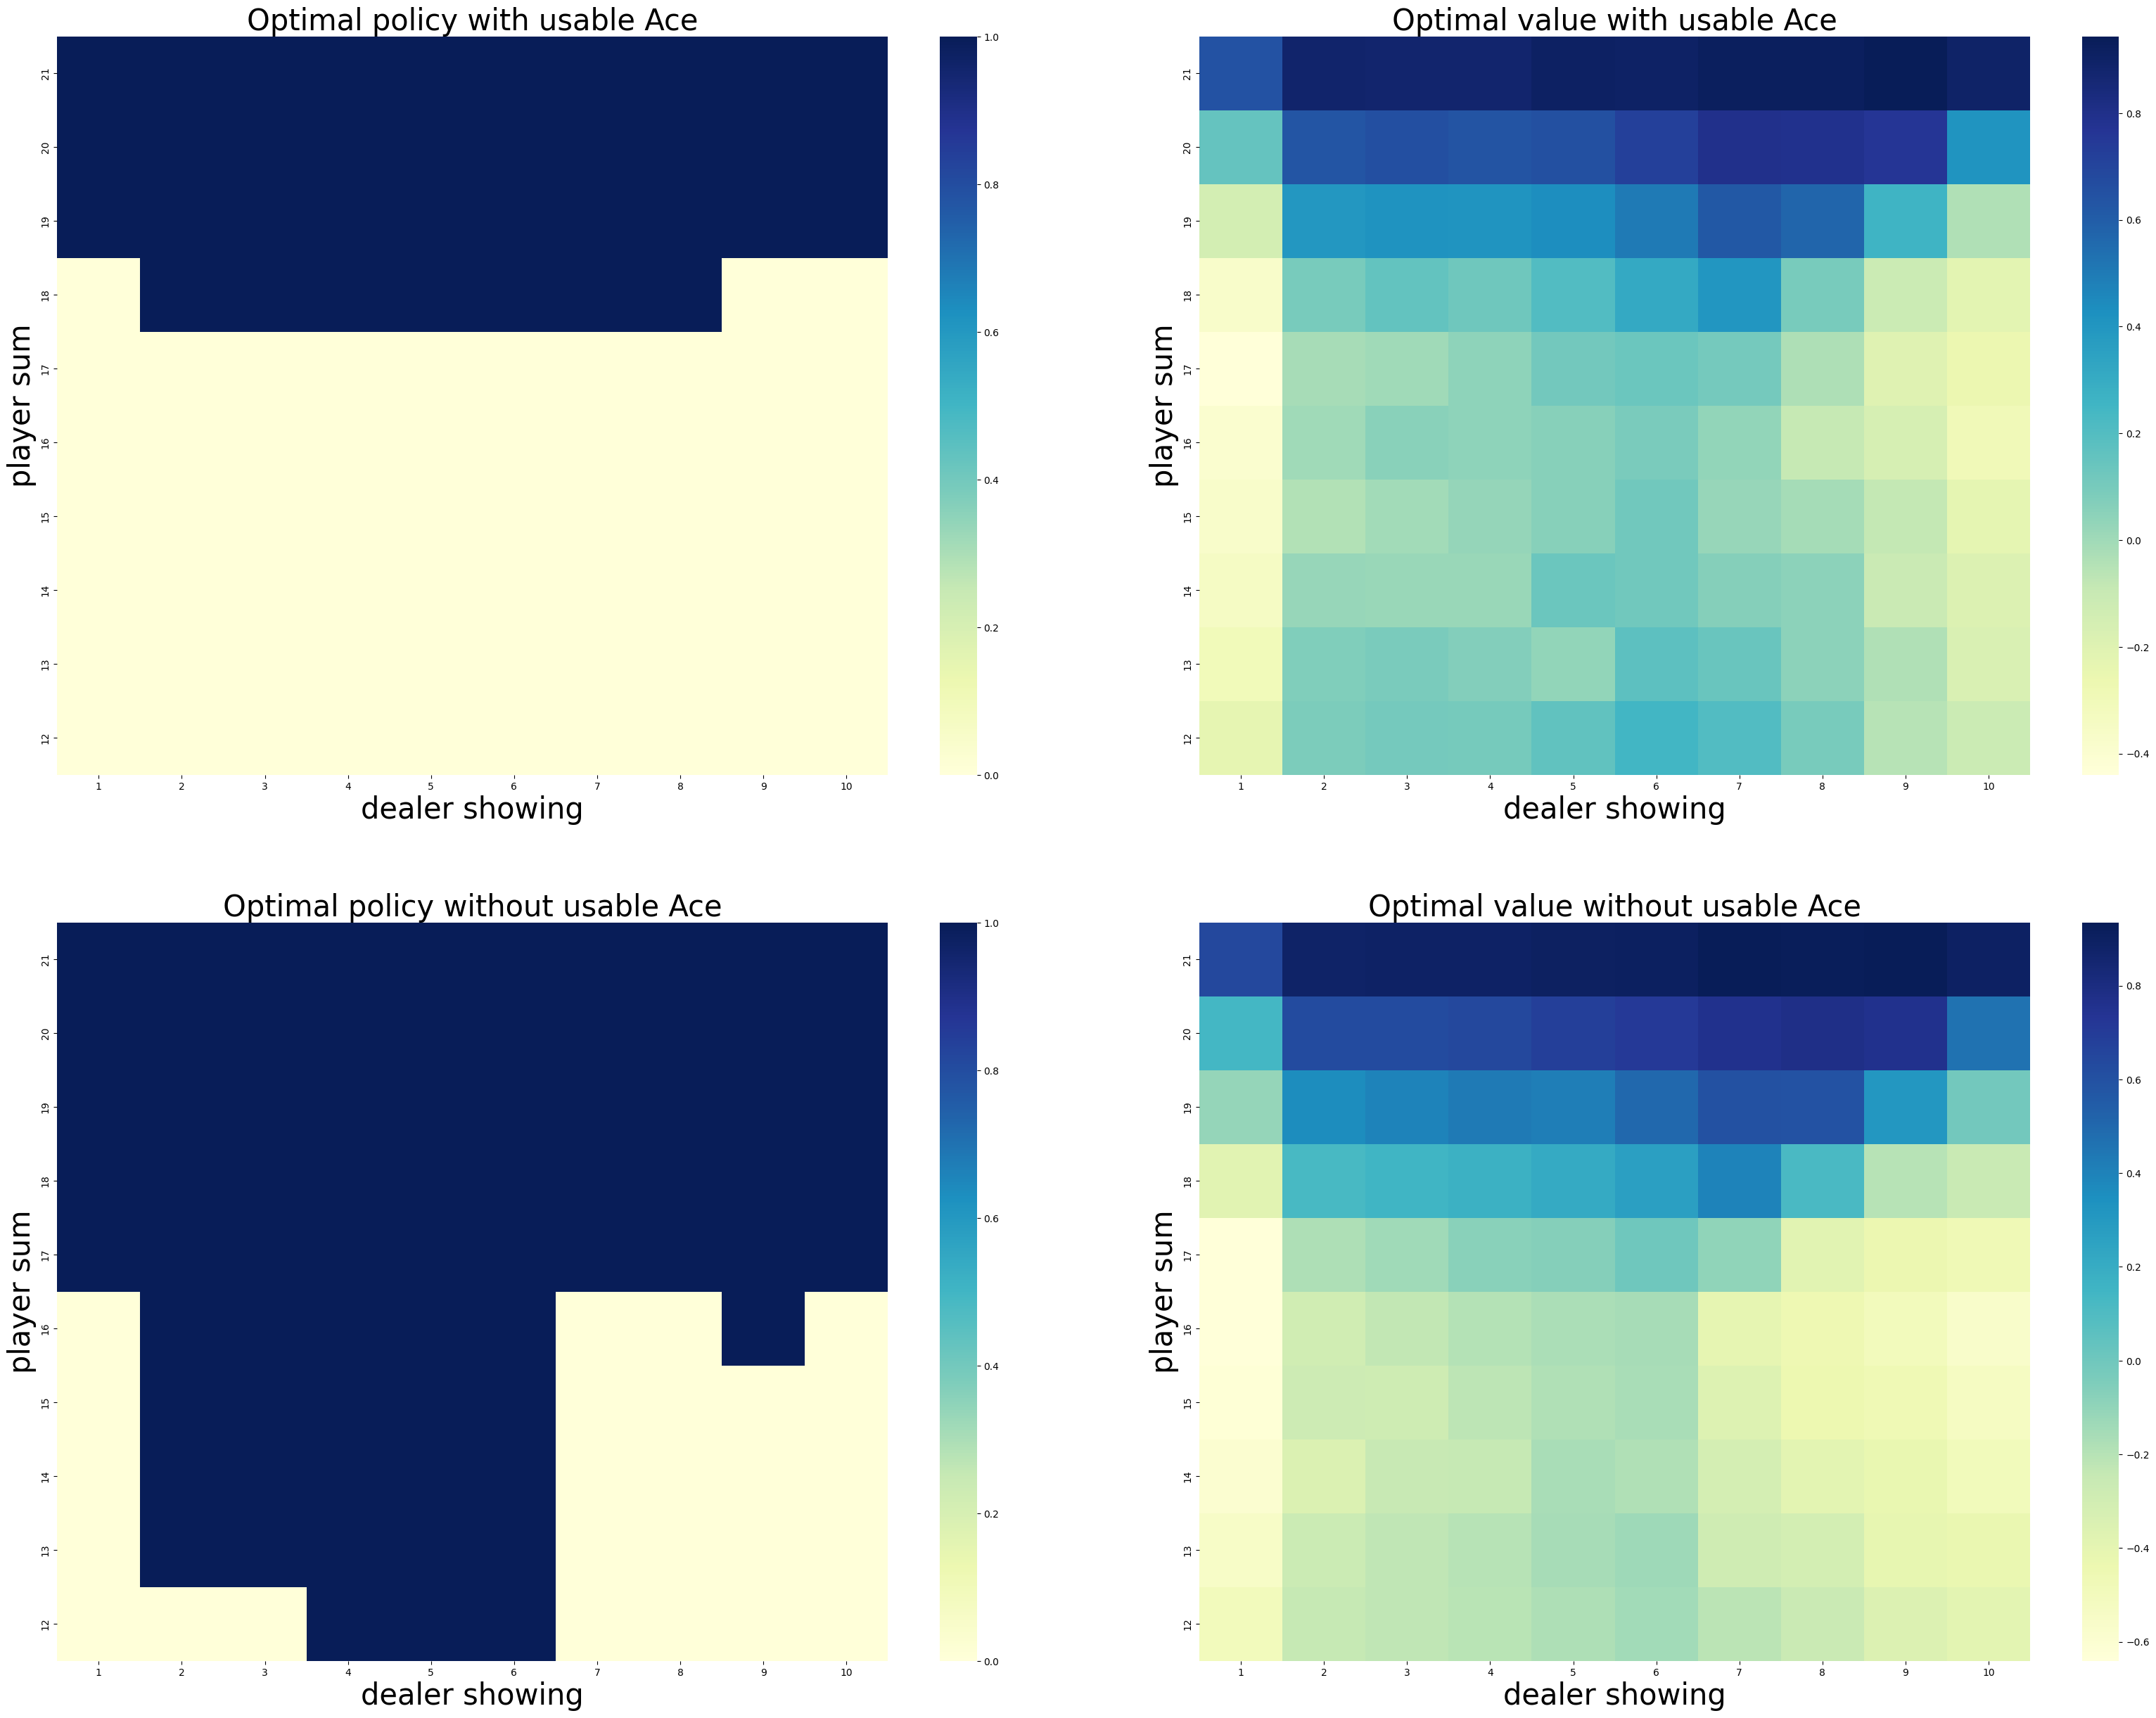

In [ ]:
test_MC_ExplorationStart()

### MC sobre una Política (MC on-policy)

Los métodos **On-policy** intentan evaluar o mejorar la política que se utiliza para tomar decisiones. Los metodos de control **on-policy** su política es generalmente *suave*, es decir que $\pi(a|s) > 0$ para todo $s \in S$ para toda $a \in A(s)$, pero gradualmente se fue acercando cada vez más a una política óptima determinista.

En este trabajo se muestra una política $\epsilon-greedy$, es decir, que el mayor tiempo se escoge una acción que estime el máximo valor para la acción, pero con probabilidad de $\epsilon$, en lugar de eso, seleccionan una acción al azar.

Igual al método de Monte Carlo ES, utilizamos métodos de MC de primera visita para estimar la funcion valor de la cción par ala política actual. Sin embargo, sin el supuesto de que se inicia la exploración, no podemos ismplemente mejorar la política haciéndola codiciosa con respecto a la función de valor actual, porque eso impediría una mayor exploración de acciones no cidciosas. En nuestro método es función de la política, la moveremoe solo a una política codiciosa.

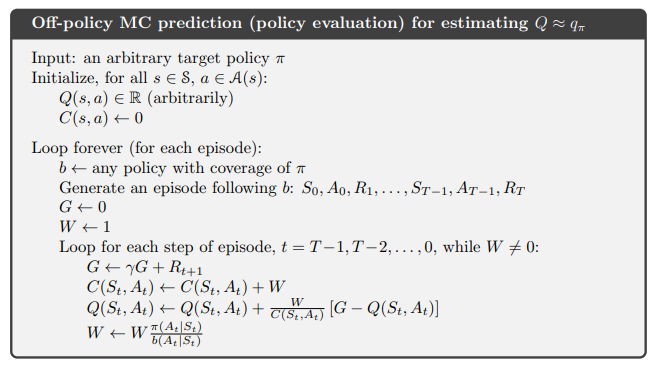

In [ ]:
def monte_carlo_on_policy(episodes):
    states_usable_ace = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    states_usable_ace_count = np.ones((10, 10))
    states_no_usable_ace = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    states_no_usable_ace_count = np.ones((10, 10))
    for i in tqdm(range(0, episodes)):
        _, reward, player_trajectory = play(target_policy_player)
        for (usable_ace, player_sum, dealer_card), _ in player_trajectory:
            player_sum -= 12
            dealer_card -= 1
            if usable_ace:
                states_usable_ace_count[player_sum, dealer_card] += 1
                states_usable_ace[player_sum, dealer_card] += reward
            else:
                states_no_usable_ace_count[player_sum, dealer_card] += 1
                states_no_usable_ace[player_sum, dealer_card] += reward
    return states_usable_ace / states_usable_ace_count, states_no_usable_ace / states_no_usable_ace_count


In [ ]:
def test_MC_on_policy():
    states_usable_ace_1, states_no_usable_ace_1 = monte_carlo_on_policy(10000)
    states_usable_ace_2, states_no_usable_ace_2 = monte_carlo_on_policy(500000)

    states = [states_usable_ace_1,
              states_usable_ace_2,
              states_no_usable_ace_1,
              states_no_usable_ace_2]

    titles = ['Usable Ace, 10000 Episodes',
              'Usable Ace, 500000 Episodes',
              'No Usable Ace, 10000 Episodes',
              'No Usable Ace, 500000 Episodes']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for state, title, axis in zip(states, titles, axes):
        fig = sns.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)

    plt.show()

100%|██████████| 500000/500000 [00:14<00:00, 35572.09it/s]


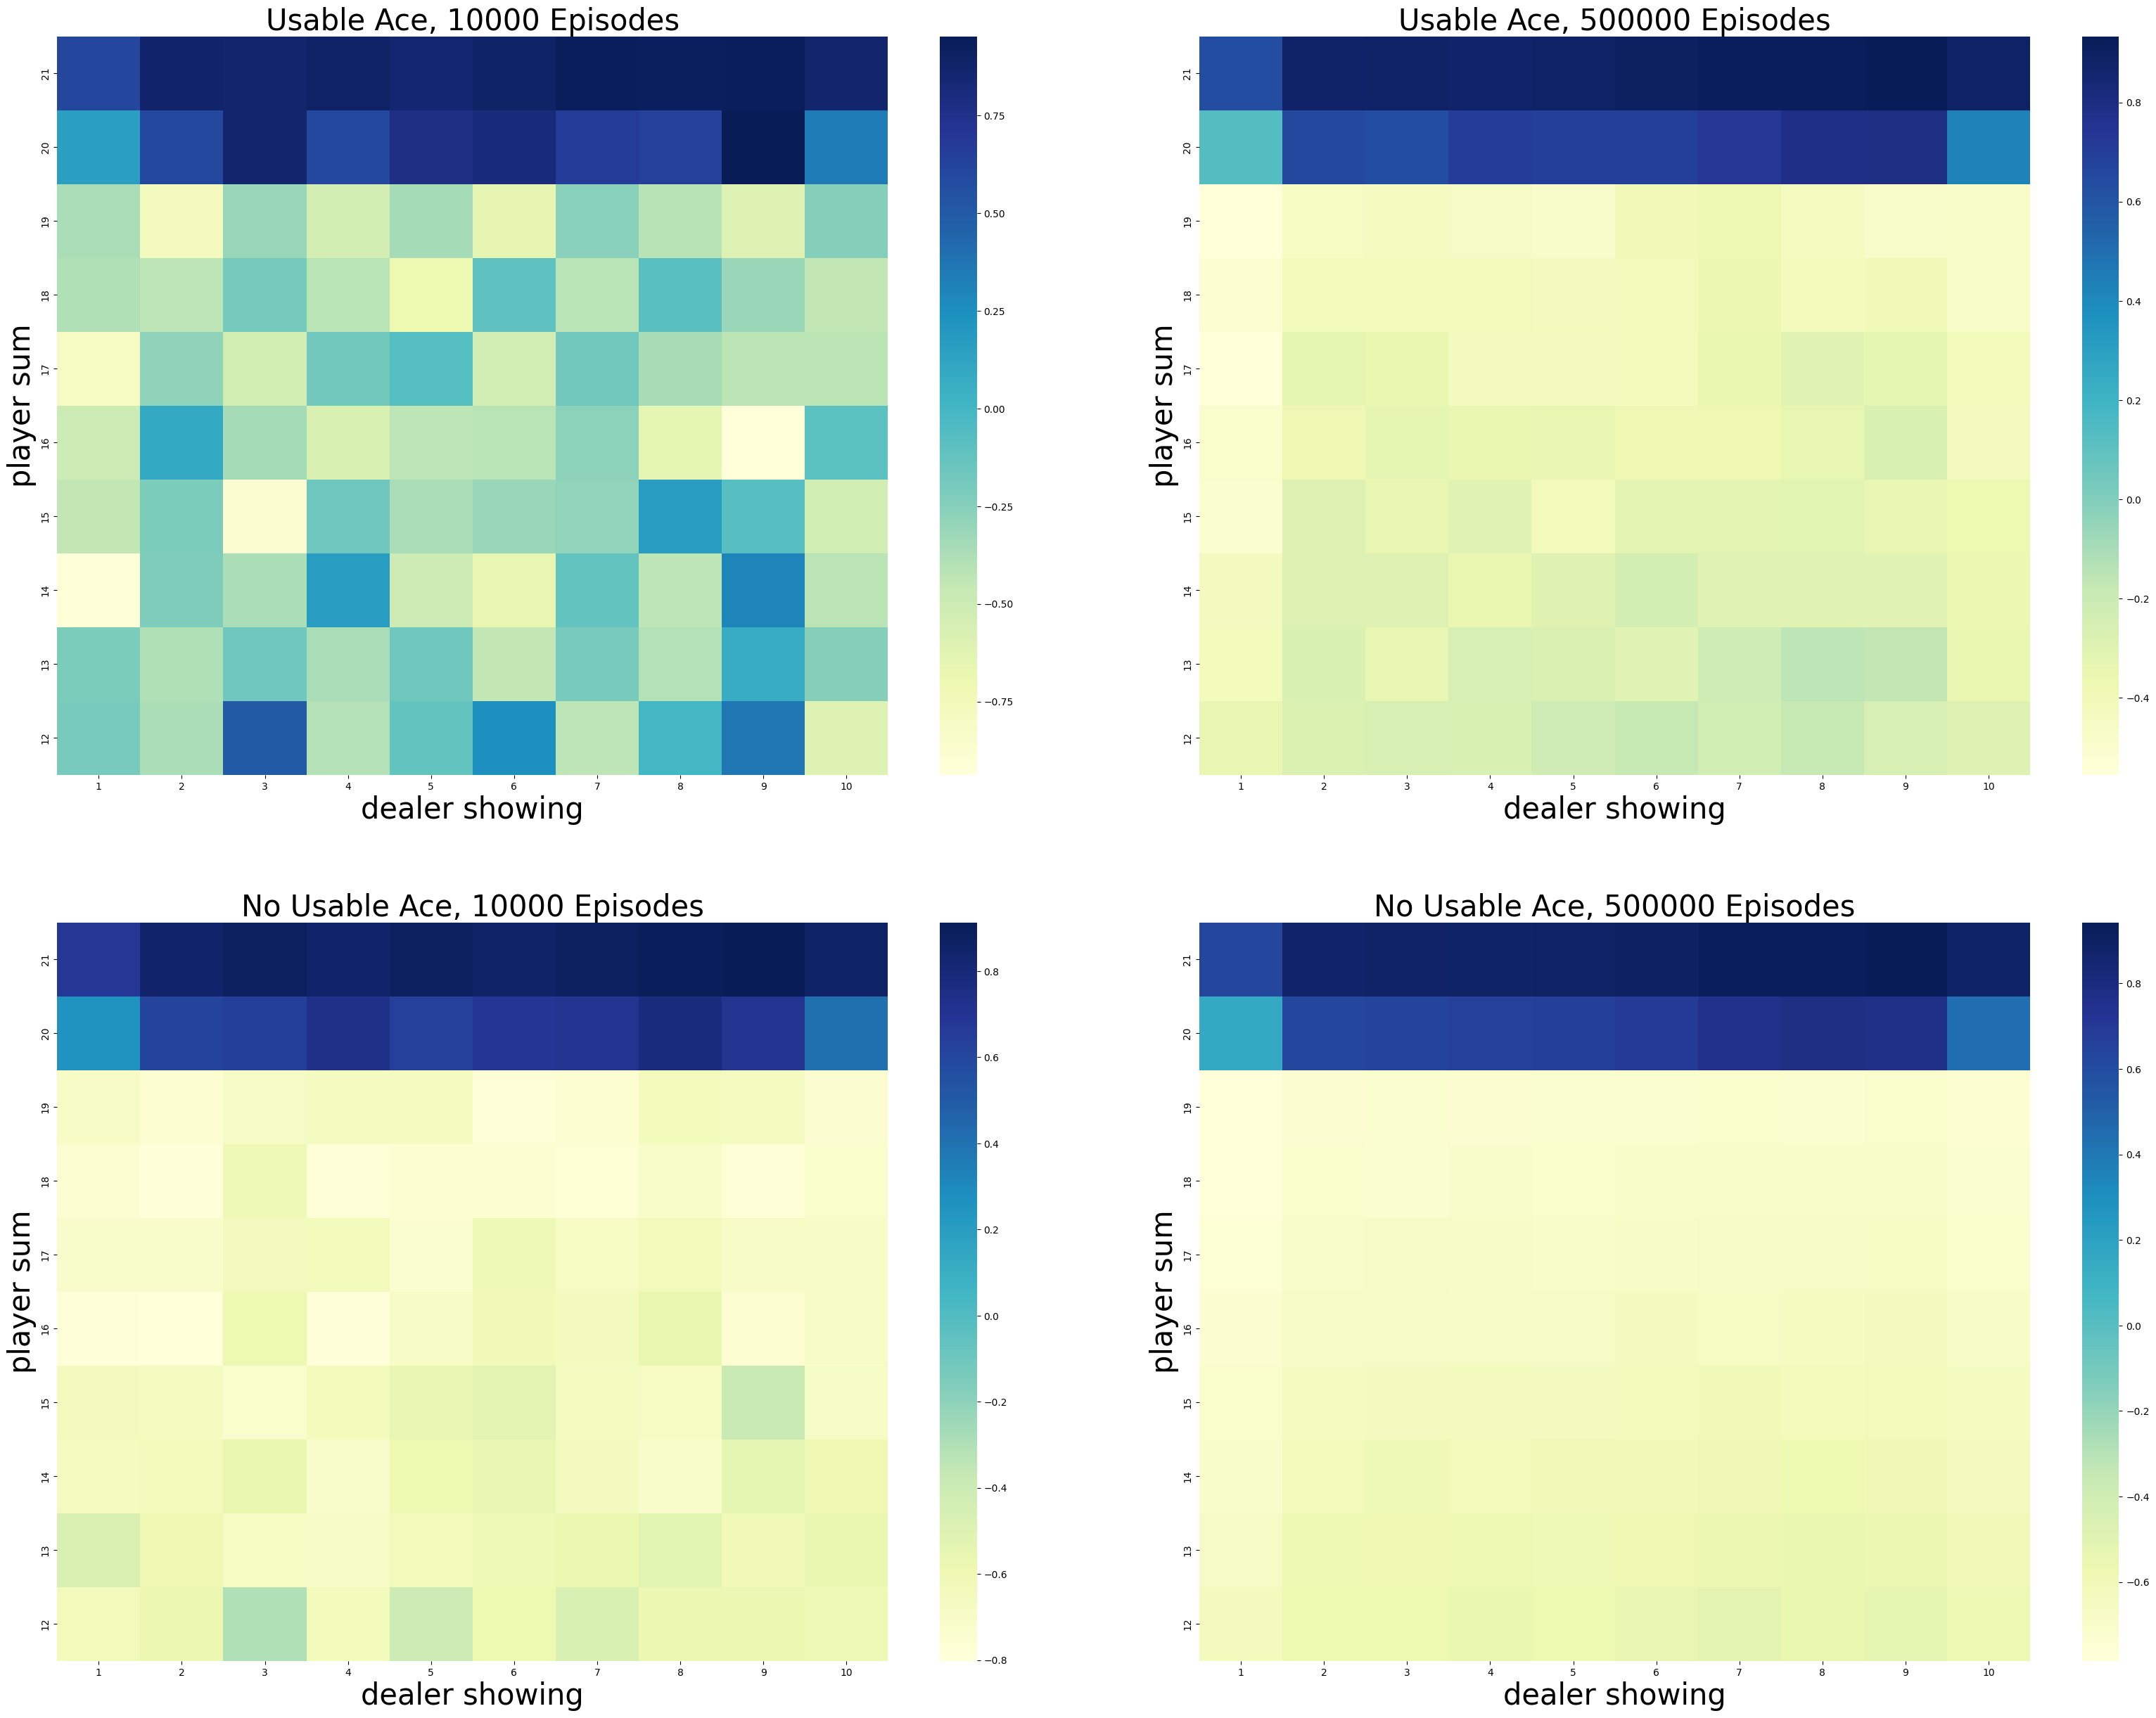

In [ ]:

test_MC_on_policy()

### MC fuera de la Politica (MC off-policy)

El enfoque **on-policy** es en realidad un compromiso - aprende valores de acción no para la política óptima, sino para una política casi óptima que aún explora.

Un enfoque más sencillo es utilizar dos políticas, una que se aprende y que se convierte en la política óptima, y otra que es más exploratoria y se utiliza para generar comportamiento. La política que se aprende se denomina política objetivo, y la pollítica utilizada para generar el comportmaiento se denomina política de comportamiento. En este caso, decimos que el aprendizaje se realiza a partir de datos **off-policy**.

Los métodos **off-policy** suelen tener una mayor vaianza y son más lentos para converger. Por otra parte, este métodos son más potentes y generales. Incluyen métodos de política **on-policy** y como el caso especial en el que las políticas objetivo y de comportamiento son las mismas.

A menudo estas políticas se usan para aprender de los datos generados por un contralador convencional que no aprned, o de un experto humano. El aprendizaje de **off-policy** también es visto por algunos como clave para aprender modelos predictivos de múltiples pasos de la dinámica del mundo.



Aplicamos para este ejemplo la importancia ponderada y ordinaria para estimar el valor de un solo estado de Blackjack a partir de datos de la **off-policy**.
En este ejemplo, evaluamos el estado en el que el dealer muestra un dos, la suma de las cartas del jugador es 13 y el jugador tiene un AS utilizable (es decir, el jugador tiene un AS y un 2, o equivalente 3 ASES).

Los datos se generan comenzando en este estado y luego eligiendo pedir carta o plantarse al azar con la misma probabilidad (política de comportmaiento). La política objetivo era plantarse solo en una suma de 20 o 21. El valor de este estado bajo la política objetivo es aproximadamente $0.27726$ (determinado por la generación de 5 millones de episodios utilizando la política objetivo y promediando sus entornos).

In [ ]:
def monte_carlo_off_policy(episodes):
    initial_state = [True, 13, 2]

    rhos = []
    returns = []

    for i in range(0, episodes):
        _, reward, player_trajectory = play(behavior_policy_player, initial_state=initial_state)

        # get the importance ratio
        numerator = 1.0
        denominator = 1.0
        for (usable_ace, player_sum, dealer_card), action in player_trajectory:
            if action == target_policy_player(usable_ace, player_sum, dealer_card):
                denominator *= 0.5
            else:
                numerator = 0.0
                break
        rho = numerator / denominator
        rhos.append(rho)
        returns.append(reward)

    rhos = np.asarray(rhos)
    returns = np.asarray(returns)
    weighted_returns = rhos * returns

    weighted_returns = np.add.accumulate(weighted_returns)
    rhos = np.add.accumulate(rhos)

    ordinary_sampling = weighted_returns / np.arange(1, episodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)

    return ordinary_sampling, weighted_sampling

In [ ]:
def test_MC_offPolicy():
    true_value = -0.27726
    episodes = 10000
    runs = 100
    error_ordinary = np.zeros(episodes)
    error_weighted = np.zeros(episodes)
    for i in tqdm(range(0, runs)):
        ordinary_sampling_, weighted_sampling_ = monte_carlo_off_policy(episodes)
        # get the squared error
        error_ordinary += np.power(ordinary_sampling_ - true_value, 2)
        error_weighted += np.power(weighted_sampling_ - true_value, 2)
    error_ordinary /= runs
    error_weighted /= runs

    plt.plot(np.arange(1, episodes + 1), error_ordinary, color='green', label='Ordinary Importance Sampling')
    plt.plot(np.arange(1, episodes + 1), error_weighted, color='red', label='Weighted Importance Sampling')
    plt.ylim(-0.1, 5)
    plt.xlabel('Episodes (log scale)')
    plt.ylabel(f'Mean square error\n(average over {runs} runs)')
    plt.xscale('log')
    plt.legend()

    plt.show()

100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


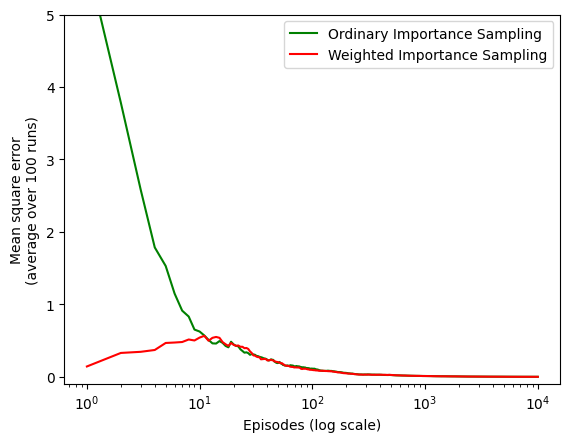

In [ ]:
test_MC_offPolicy()

Ambos métodos de política off-policy se aproxiamron bastante a ese valor despues de 1000 episodios usando la política aleatoria. Para asegurarnos de que lo hiceran de manera confiable realizamos 100 ejecuciones independientes, cada uan comenzando con estimaciones de cero y aprendiendo para 10,000 episodios. Aqui se muestran las curvas de aprendizaje resultante, el error cuadrado de las estimaciones de cada método con función del número de episodios, promediando a lo largo de las 100 ejecuciones. El error se acerca a cero para ambos algoritmos, pero el método de muestreo de importancia ponderada tiene un error mucho menos al comienzo, como es típico en la práctica.